# Continuous Hopfield Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import pysindy as ps
from sklearn.metrics import r2_score, mean_squared_error
import scienceplots
plt.style.use(["science", "notebook", "grid"])

In [35]:
def hopfield2d(t, x, weights=[1, -1], activation_type="sigmoid"):
    # weights = [J_12, J_21]
    
    try:
        if activation_type == "sigmoid":
            return [-x[0] + 1 / (1 + np.exp(- weights[0] * x[1])),
                    -x[1] + 1 / (1 + np.exp(- weights[1] * x[0]))]
            
        elif activation_type == "tanh":
            return [1/2 - x[0] + (1/2)*np.tanh(weights[0] * x[1]),
                    1/2 - x[1] + (1/2)*np.tanh(weights[1] * x[0])]
            
        else:
            raise ValueError("Invalid activation type. Must be 'sigmoid' or 'tanh'.")

    except TypeError:
        raise Exception("Input must be a string for the activation_type argument and list for weights.")

In [32]:
# 2D model
delta_t = 0.01
t = np.arange(0, 30, delta_t)
x0 = [0.5, 0.75]

# library
lib1 = ps.PolynomialLibrary(degree=1) # bias included by default
# tanh library
functions_tanh = [lambda x: np.tanh(x), lambda x: np.tanh(-x)]
functions_names_tanh = [lambda x: "tanh(" + x + ")", lambda x: "tanh(-" + x + ")"]
lib2_tanh = ps.CustomLibrary(library_functions=functions_tanh, function_names=functions_names_tanh)
lib_tanh = ps.GeneralizedLibrary([lib1, lib2_tanh])
# sigmoid library
functions_sig = [lambda x: 1 / (1 + np.exp(-x)), lambda x: 1 / (1 + np.exp(x))]
functions_names_sig = [lambda x: "1/(1+exp(-" + x + "))", lambda x: "1/(1+exp(" + x + "))"]
lib2_sig = ps.CustomLibrary(library_functions=functions_sig, function_names=functions_names_sig)
lib_sig = ps.GeneralizedLibrary([lib1, lib2_sig])

# optimization and diffferentiation method
# opt = ps.STLSQ(threshold=0.005)
opt = ps.SR3(threshold=0.025, thresholder="L1")
diff = ps.FiniteDifference()
features = ["x1", "x2"]

weights = [[1, -1], [-1, 1], [1, 1], [-1, -1]]
activations = ["sigmoid", "tanh"]

In [34]:
fp_dict = {}

for activation in activations:
    for weight in weights:
        fp = fsolve(lambda x: hopfield2d(x, weights=weight, activation_type=activation), (0.5,0.5)) # remove t from function
        fp_dict[f"{activation}-{weight}"] = fp
        print(f"Weight {weight}\tActivation {activation}\n{fp}\n")

Weight [1, -1]	Activation sigmoid
[0.58831902 0.35702064]

Weight [-1, 1]	Activation sigmoid
[0.35702064 0.58831902]

Weight [1, 1]	Activation sigmoid
[0.65904607 0.65904607]

Weight [-1, -1]	Activation sigmoid
[0.40105814 0.40105814]

Weight [1, -1]	Activation tanh
[0.61174348 0.22732339]

Weight [-1, 1]	Activation tanh
[0.22732339 0.61174348]

Weight [1, 1]	Activation tanh
[0.843947 0.843947]

Weight [-1, -1]	Activation tanh
[0.33741581 0.33741581]



# Some Plots

In [62]:
# initial_conditions = [[0.9, 0.1], [0.2, 0.6], [0.32, 0.01], [0.58, 0.98]]
# delta_t = 0.01
# t = np.arange(0, 30, delta_t)
# colors = ['r', 'g', 'b', 'c']  # Define colors for the lines

# plt.figure(figsize=(8, 6))

# for i, x0 in enumerate(initial_conditions):
#     np.random.seed(42)
#     x_train = solve_ivp(lambda t, x: hopfield2d(t, x, activation_type="tanh"), (t[0], t[-1]), x0, t_eval=t, rtol=1e-12, method="LSODA", atol=1e-12).y.T
#     x = x_train[:, 0]
#     y = x_train[:, 1]
#     plt.plot(x, y, color=colors[i], label=f"${x0}$")
#     plt.scatter(x0[0], x0[1], color=colors[i], marker='o')  # Plot initial condition point with the same color

# # plt.plot(0.58831902, 0.35702064, 'ko', markersize=8)
# # plt.text(0.59, 0.37, "fixed point", fontsize = 10)
# plt.xlabel("$x$")
# plt.ylabel("$y$")
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.title("Phase Plot with multiple initial conditions")
# plt.legend()
# plt.show()

In [61]:
# plt.plot(t, y, label = "y")
# plt.plot(t, x, label = "x")
# plt.legend()
# plt.show()

# Some Functions

In [47]:
def plot_phase_plane(x, y, model_sim_x, model_sim_y, x0, fp, title=""):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, c="k", label="True")
    plt.plot(model_sim_x, model_sim_y, "r--", label="SINDy")
    plt.plot(fp[0], fp[1], 'ko', markersize=8)
    plt.text(fp[0]+0.025, fp[1]+0.025, "Fixed point", fontsize = 10)
    plt.plot(x0[0], x0[1], c="k", markersize=15)
    # plt.text(fp[0]+0.025, fp[1]+0.025, "Fixed point", fontsize = 10)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend()
    plt.title(f"Phase plane {title}")
    plt.show()

def plot_time_series(t, x, y, model_sim_x, model_sim_y, title=""):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    axes[0].plot(t, x, label='True', c="k")
    axes[0].plot(t, model_sim_x, "r--", label='SINDy')
    axes[0].set_ylabel('$x_1$', fontsize=15)
    axes[0].set_ylim((0,1))
    axes[0].legend(loc="lower right", prop={'size': 10})
    axes[0].xaxis.set_ticklabels([])
    axes[0].yaxis.set_tick_params(labelsize=10)

    axes[1].plot(t, y, label='True', c="k")
    axes[1].plot(t, model_sim_y, "r--", label='SINDy')
    axes[1].set_ylabel('$x_2$', fontsize=15)
    axes[1].set_ylim((0,1))
    axes[1].xaxis.set_tick_params(labelsize=10)
    axes[1].yaxis.set_tick_params(labelsize=10)
    plt.suptitle(f"True vs SINDy in $(x_1,x_2)$ {title}")
    plt.tight_layout()
    plt.show()

In [29]:
def simulate_model(weight, activation, lib):
    x_train = solve_ivp(lambda t, x: hopfield2d(t, x, weights=weight, activation_type=activation), (t[0], t[-1]), x0, t_eval=t, rtol=1e-12, method="LSODA", atol=1e-12).y.T
    x_dot = np.array([hopfield2d(0, x_train[t], weights=weight, activation_type=activation) for t in range(t.size)])
    x = x_train[:, 0]
    y = x_train[:, 1]
    model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=diff, feature_names=features)
    model.fit(x_train, t, x_dot)
    model_sim = model.simulate(x0, t)
    model_sim_x = model_sim[:, 0]
    model_sim_y = model_sim[:, 1]
    r2 = model.score(x_train, t, x_dot, metric=r2_score)
    mse = model.score(x_train, t, x_dot, metric=mean_squared_error)
    
    return model, x, y, model_sim_x, model_sim_y, r2, mse

# Models

Model with J_12=1, J_21=-1	Activation sigmoid
(x1)' = -1.000 x1 + 1.000 1/(1+exp(-x2))
(x2)' = -1.000 x2 + 1.000 1/(1+exp(x1))
R2: 1.0	MSE: 0.0


c:\Users\sandr\anaconda3\envs\sindy\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


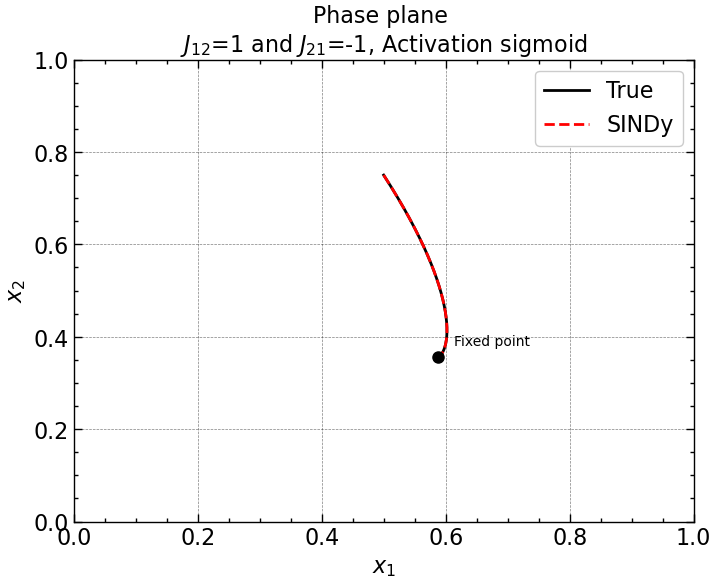

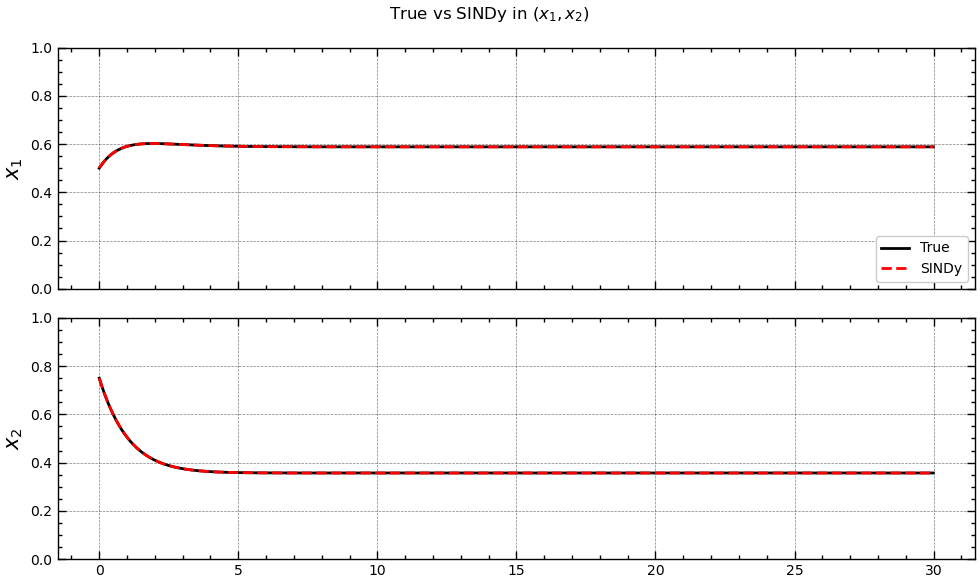

Model with J_12=-1, J_21=1	Activation sigmoid
(x1)' = -1.000 x1 + 1.000 1/(1+exp(x2))
(x2)' = -1.000 x2 + 1.000 1/(1+exp(-x1))
R2: 1.0	MSE: 0.0


c:\Users\sandr\anaconda3\envs\sindy\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


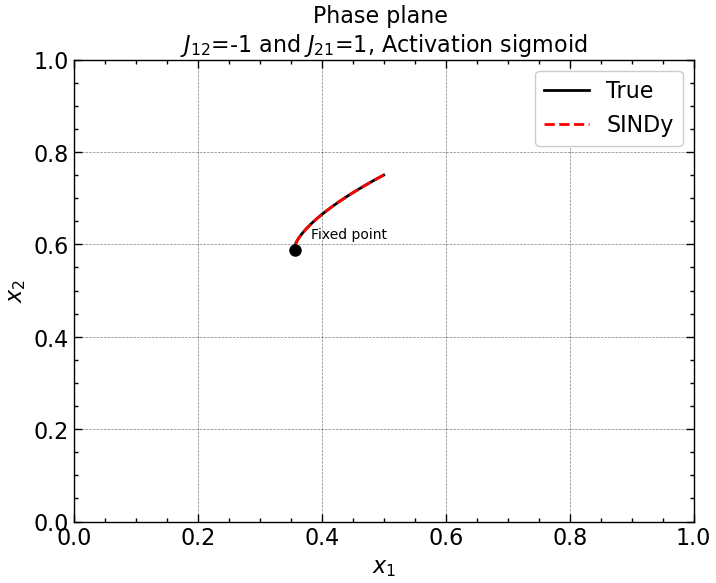

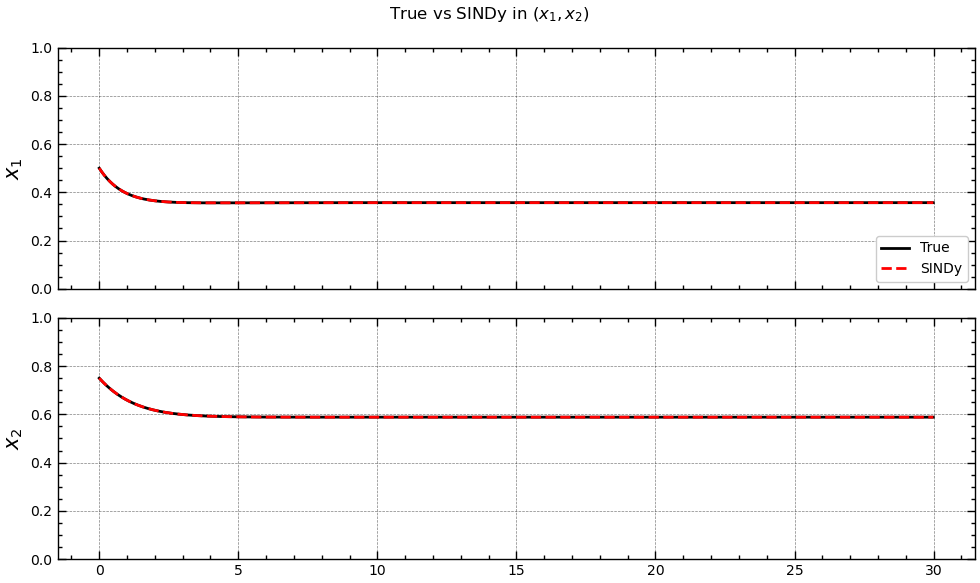

Model with J_12=1, J_21=1	Activation sigmoid
(x1)' = -1.000 x1 + 1.000 1/(1+exp(-x2))
(x2)' = -1.000 x2 + 1.000 1/(1+exp(-x1))
R2: 1.0	MSE: 0.0


c:\Users\sandr\anaconda3\envs\sindy\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


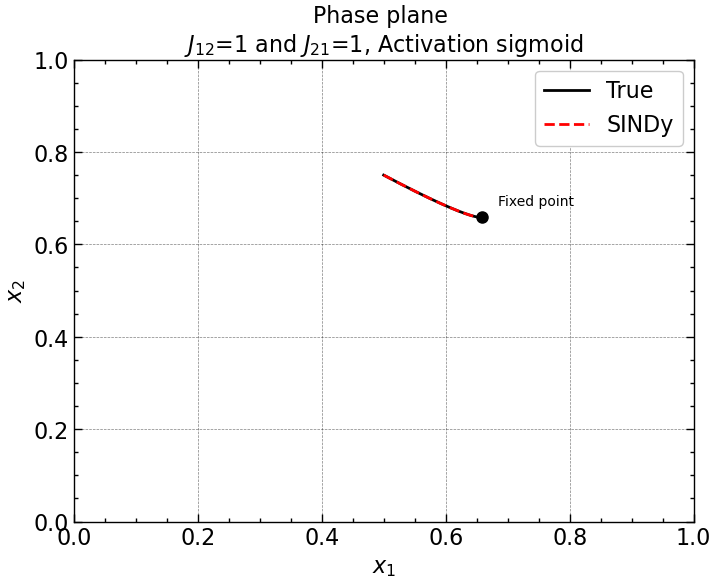

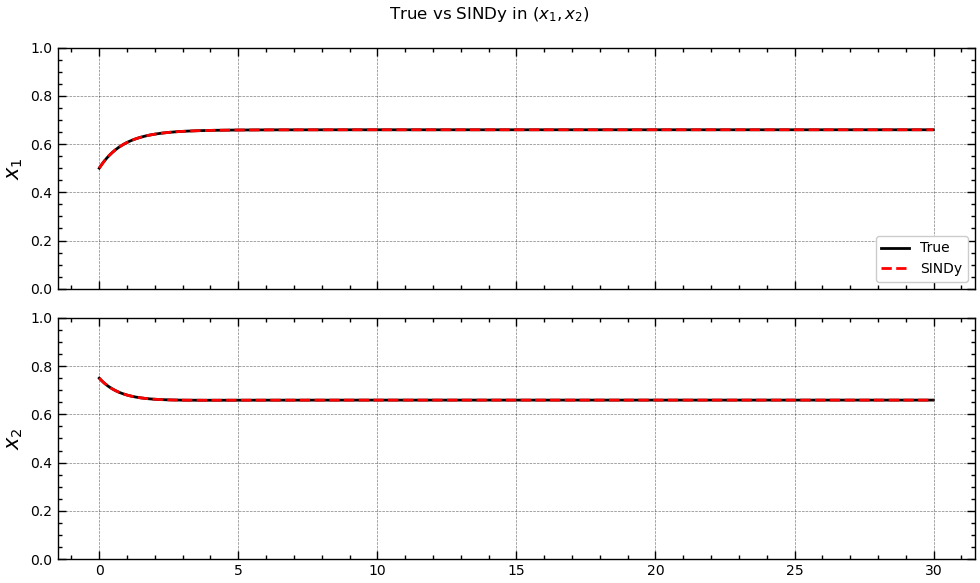

Model with J_12=-1, J_21=-1	Activation sigmoid
(x1)' = -1.000 x1 + 1.000 1/(1+exp(x2))
(x2)' = -1.000 x2 + 1.000 1/(1+exp(x1))
R2: 1.0	MSE: 0.0


c:\Users\sandr\anaconda3\envs\sindy\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


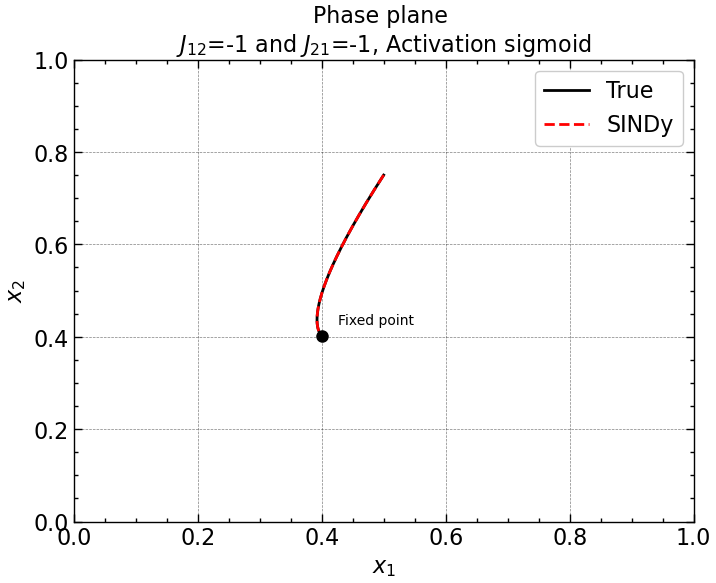

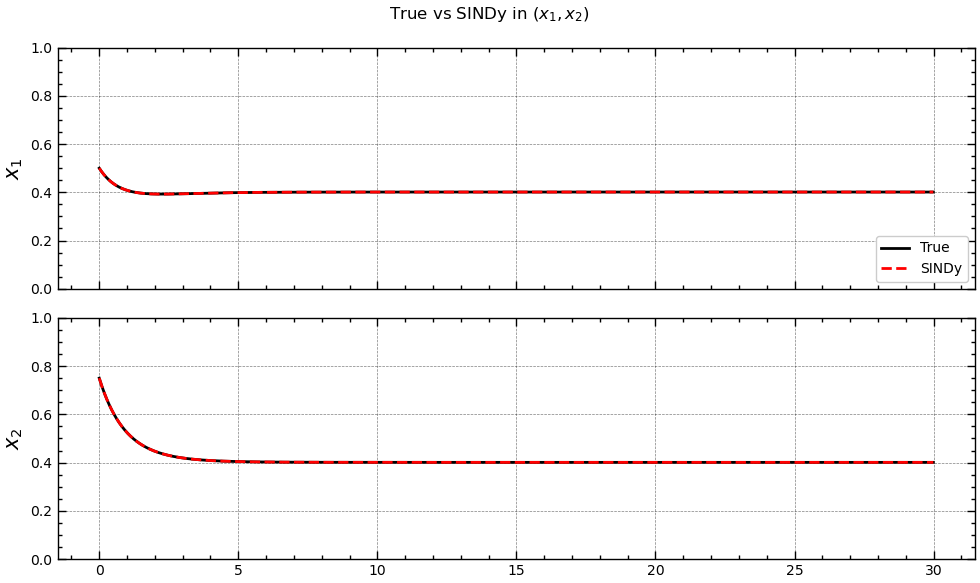

Model with J_12=1, J_21=-1	Activation tanh
(x1)' = 0.500 1 + -1.000 x1 + 0.250 tanh(x2) + -0.250 tanh(-x2)
(x2)' = 0.500 1 + -1.000 x2 + -0.250 tanh(x1) + 0.250 tanh(-x1)
R2: 1.0	MSE: 0.0


c:\Users\sandr\anaconda3\envs\sindy\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


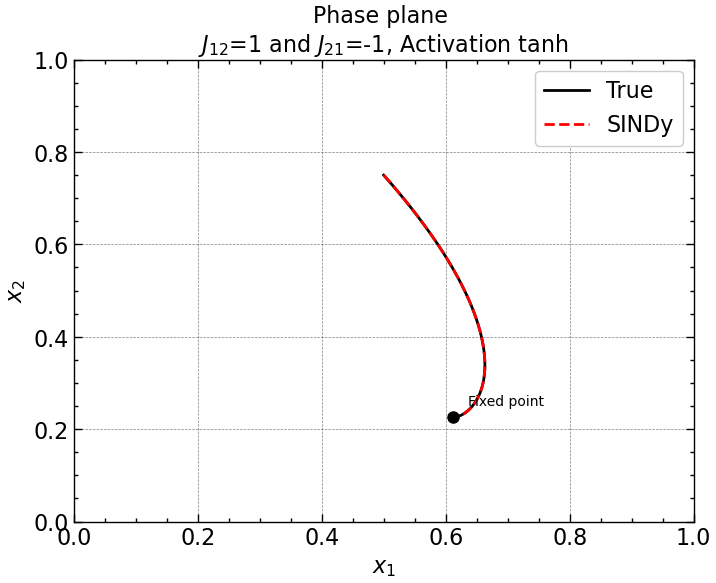

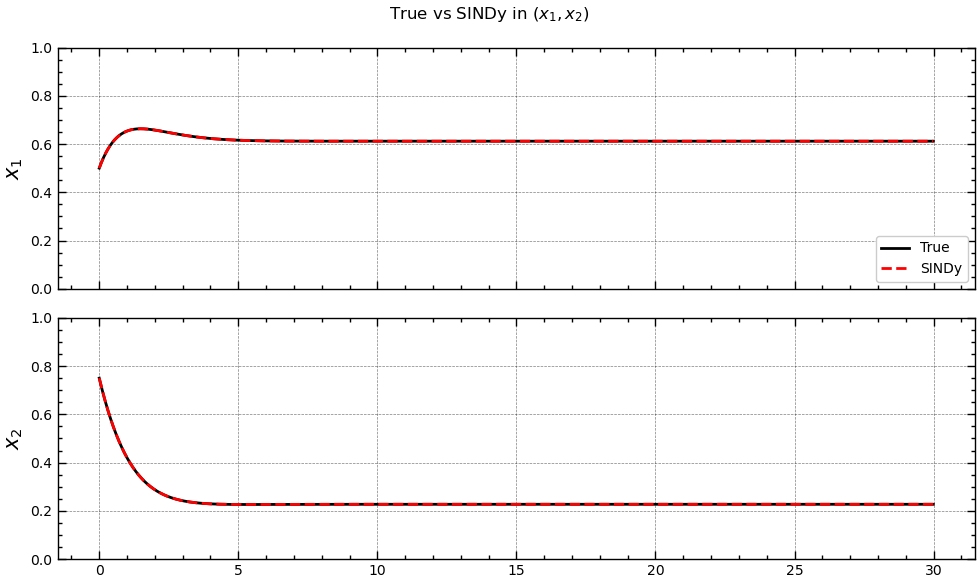

Model with J_12=-1, J_21=1	Activation tanh
(x1)' = 0.500 1 + -1.000 x1 + -0.250 tanh(x2) + 0.250 tanh(-x2)
(x2)' = 0.500 1 + -1.000 x2 + 0.250 tanh(x1) + -0.250 tanh(-x1)
R2: 1.0	MSE: 0.0


c:\Users\sandr\anaconda3\envs\sindy\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


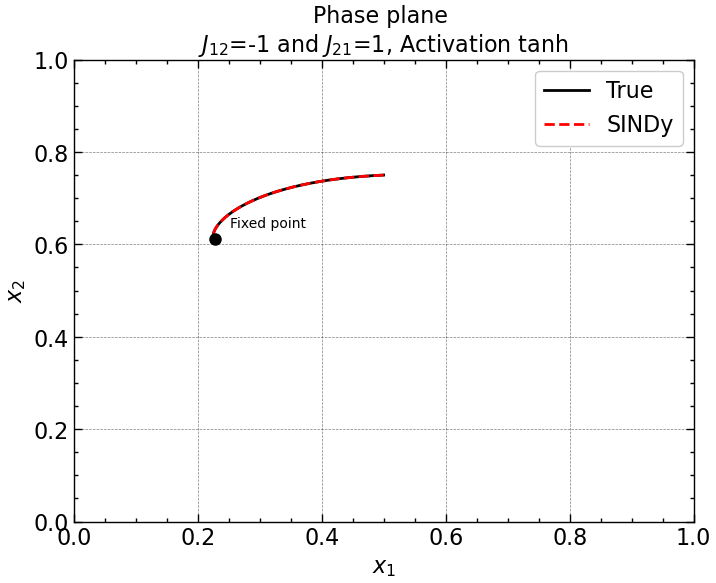

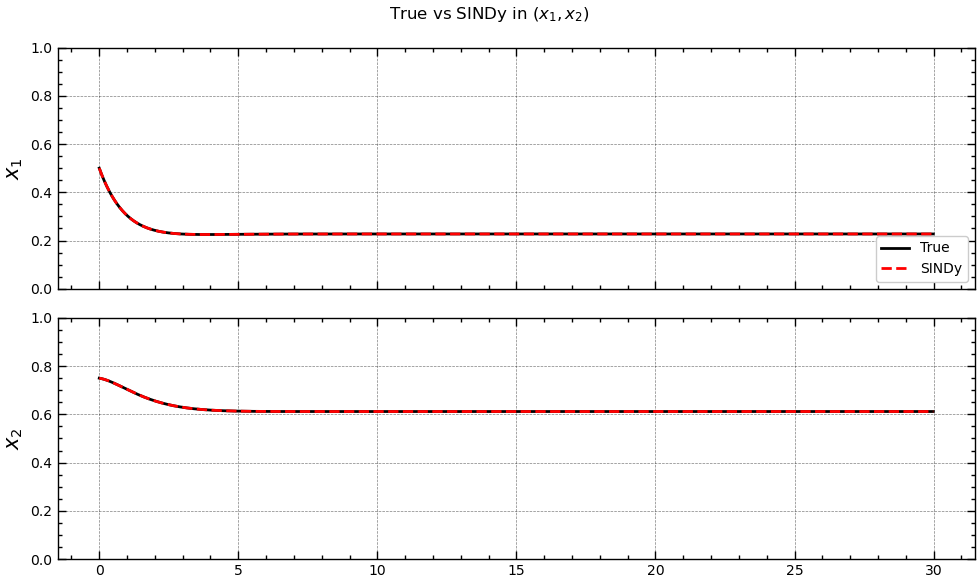

Model with J_12=1, J_21=1	Activation tanh
(x1)' = 0.500 1 + -1.000 x1 + 0.250 tanh(x2) + -0.250 tanh(-x2)
(x2)' = 0.500 1 + -1.000 x2 + 0.250 tanh(x1) + -0.250 tanh(-x1)
R2: 1.0	MSE: 0.0


c:\Users\sandr\anaconda3\envs\sindy\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


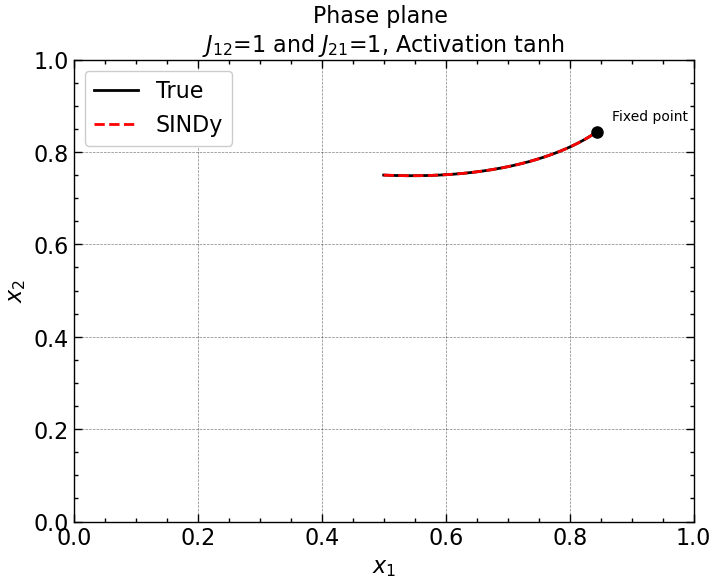

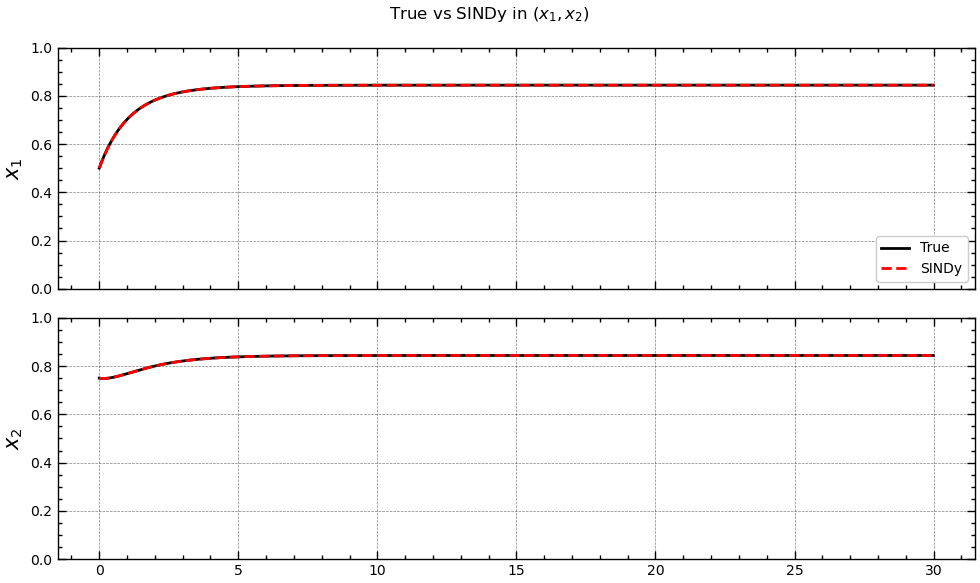

Model with J_12=-1, J_21=-1	Activation tanh
(x1)' = 0.500 1 + -1.000 x1 + -0.250 tanh(x2) + 0.250 tanh(-x2)
(x2)' = 0.500 1 + -1.000 x2 + -0.250 tanh(x1) + 0.250 tanh(-x1)
R2: 1.0	MSE: 0.0


c:\Users\sandr\anaconda3\envs\sindy\Lib\site-packages\pysindy\optimizers\sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


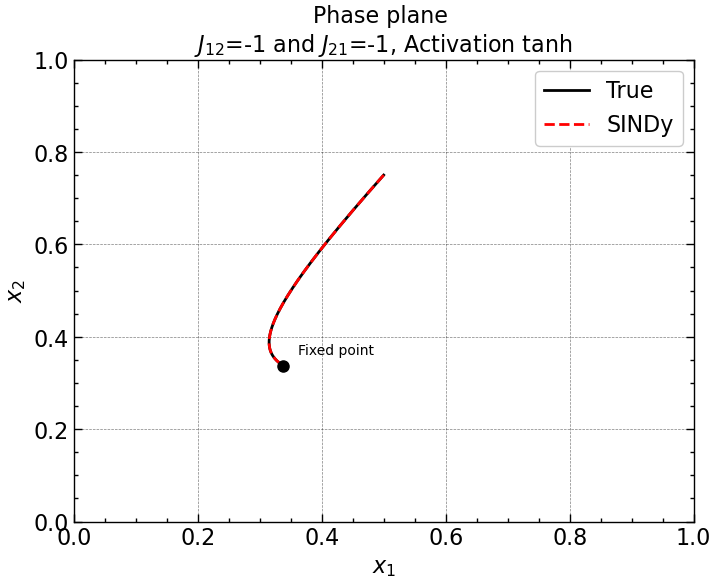

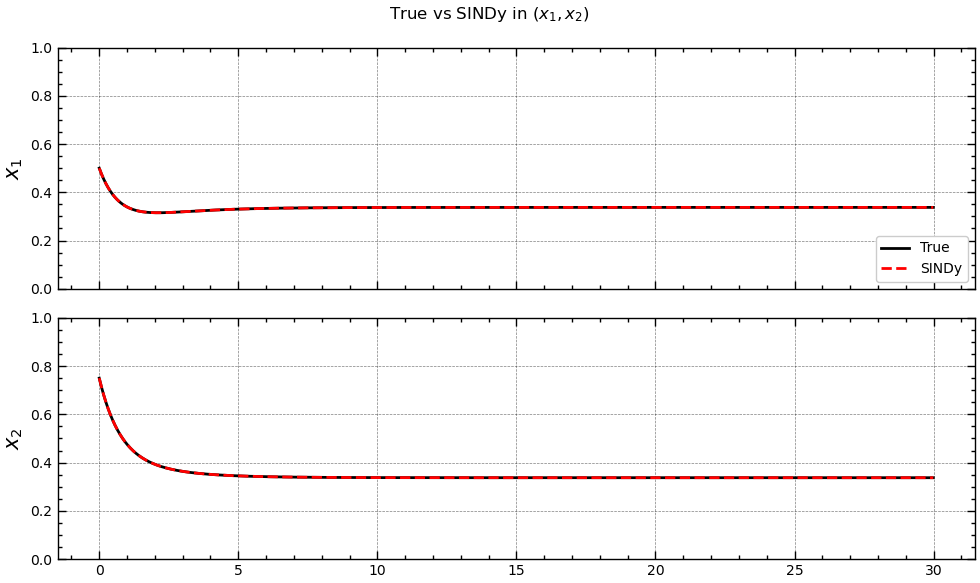

In [48]:
r2_dict = {}
i = 0
for activation in activations:
    
    if activation == "sigmoid":
        lib = lib_sig
    elif activation == "tanh":
        lib = lib_tanh
        
    for weight in weights:
        
        fp = fp_dict[f"{activation}-{weight}"]
        print(f"Model with J_12={weight[0]}, J_21={weight[1]}\tActivation {activation}")
        model, x, y, model_sim_x, model_sim_y, r2, mse = simulate_model(weight, activation, lib)
        r2_dict[f"{activation}-{weight}"] = r2
        model.print()
        print(f"R2: {r2}\tMSE: {round(mse,3)}")
        plot_phase_plane(x, y, model_sim_x, model_sim_y, x0, fp, title = f"\n$J_{{12}}$={weight[0]} and $J_{{21}}$={weight[1]}, Activation {activation}")
        plot_time_series(t, x, y, model_sim_x, model_sim_y)
        i += 1

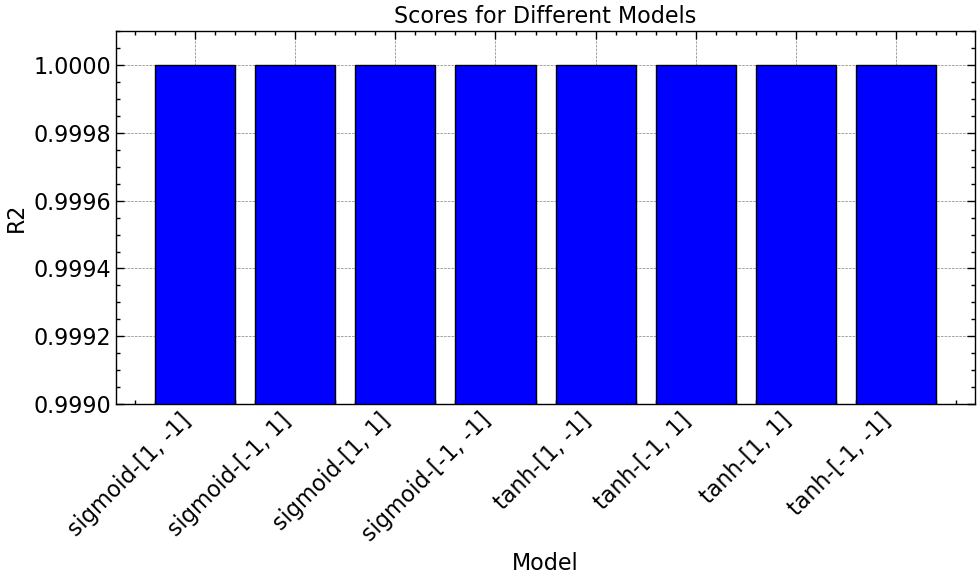

In [60]:
r2_values = list(r2_dict.values())
labels = list(r2_dict.keys())

# Creating bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, r2_values, color='blue', edgecolor='black')
plt.xlabel('Model')
plt.ylabel('R2')
plt.title('Scores for Different Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.999,1.0001)
plt.tight_layout()
plt.show()